# Supernova use case notebook

ALeRCE starter notebook for supernova science.

You will need to install psycopg2, astroquery, ipyaladin

In this notebook you will connect to the ALeRCE database, download some objects with probability greater than 0.7 of being supernova, get selected light curves and plot, as well as querying NED for galaxy crossmatches.

### Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from IPython.display import HTML

Astroquery https://astroquery.readthedocs.io/en/latest/

In [2]:
#!pip install astroquery
from astroquery.ned import Ned

Install psycopg2 https://github.com/psycopg/psycopg2

In [3]:
#!pip install psycopg2-binary
import psycopg2

Install pyaladin https://github.com/cds-astro/ipyaladin

In [4]:
# you may need to restart the notebook after running the following lines
#!pip install ipyaladin
#!jupyter nbextension enable --py widgetsnbextension
#!jupyter nbextension enable --py --sys-prefix ipyaladin

In [5]:
import ipyaladin as ipyal # see installation instructions here: https://github.com/cds-astro/ipyaladin

### Get credentials (not in github repository)

In [6]:
import json
credentials_file = "../alercereaduser.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

### Connect to DB

In [7]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

### Show all the available tables

In [8]:
query = "select tablename from pg_tables where schemaname='public';"
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="tablename")

,tablename
1,asassn
0,class
2,crtsnorth
3,crtssouth
4,detections
9,features
15,features_v2
5,insert_tmp
10,linear
12,magref


### For each table, show column names and column types

In [9]:
alltabs = []
for tab in sorted(tables.tablename):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

,table,column_name,data_type
0,asassn,ASAS-SN Name,text
1,asassn,Other Names,text
2,asassn,LCID,integer
3,asassn,ra,double precision
4,asassn,dec,double precision
5,asassn,Mean VMag,double precision
6,asassn,Amplitude,double precision
7,asassn,Period,double precision
8,asassn,Type,text
9,asassn,Url,text


### Query class numbers

In [10]:
query = "select * from class"
classes = pd.read_sql_query(query, conn)
classmapper = dict(zip(classes.name.tolist(), classes.id.tolist()))
classmapper

{'Other': 0, 'Ceph': 1, 'LPV': 4, 'RRL': 5, 'EB': 3, 'SNe': 6, 'DSCT': 2}

### Query SN which exploded at least 70 days after ZTF's 1st light

In [11]:
mjd_1stlight = Time("2017-11-01T00:00:00", format="isot", scale="utc").mjd + 70

query='''
select probabilities.oid, probabilities.other_prob, objects.meanra, 
objects.meandec, objects.nobs, objects.mean_magpsf_g, objects.mean_magpsf_r,
objects.min_magpsf_g, objects.min_magpsf_r, objects.classxmatch, objects.firstMJD

from probabilities 

inner join objects
on probabilities.oid=objects.oid

where probabilities.sne_prob>0.7 and objects.classxmatch=%s
and objects.firstMJD > %s
''' % (classmapper["SNe"], mjd_1stlight)

SNe = pd.read_sql_query(query, conn)
SNe.set_index('oid', inplace=True)
SNe.head()

,other_prob,meanra,meandec,nobs,mean_magpsf_g,mean_magpsf_r,min_magpsf_g,min_magpsf_r,classxmatch,firstmjd
oid,,,,,,,,,,
ZTF18aaygwqd,0.096,239.413764,78.612239,73,19.104803,18.601687,18.896492,17.770758,6,58275.386516
ZTF18aaqfqaa,0.070,233.006492,68.241925,69,18.350162,17.868438,17.309547,16.919594,6,58272.266806
ZTF18aauizcr,0.114,173.616142,46.362610,57,18.715630,18.249422,18.571981,17.640026,6,58279.184213
ZTF18aauxltf,0.044,224.369251,5.842305,38,19.220957,18.863461,19.060667,18.150463,6,58270.317037
ZTF18absqhza,0.082,24.046898,27.274810,32,18.634780,19.487591,18.128696,19.273539,6,58364.405521


### Create function to plot SN light curve

In [12]:
def plotLC(oid, SN_det, SN_nondet):
    fig, ax = plt.subplots(figsize = (14, 7))
    labels = {1: 'g', 2: 'r'}
    colors = {1: 'g', 2: 'r'}
    for fid in [1, 2]:
        mask = SN_det.fid == fid
        if np.sum(mask) > 0:            
            ax.errorbar(SN_det[mask].mjd, SN_det[mask].magpsf_corr, 
                yerr = SN_det[mask].sigmapsf_corr, c = colors[fid], marker = 'o', label = labels[fid])
        mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
        if np.sum(mask) > 0:            
            ax.scatter(SN_nondet[mask].mjd, SN_nondet[mask].diffmaglim, c = colors[fid], alpha = 0.5,
                marker = 'v', label = "lim.mag. %s" % labels[fid])
    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

### Create function to show stamp

In [13]:
def plotstamp(oid, candid):
    science = "http://avro.alerce.online/get_stamp?oid=%s&candid=%s&type=science&format=png" % (oid, candid)
    images="""
    &emsp;&emsp;&emsp;&emsp;&emsp;
    Science
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 
    Template
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 
    Difference
    <div class="container">
    <div style="float:left;width:20%%"><img src="%s"></div>
    <div style="float:left;width:20%%"><img src="%s"></div>
    <div style="float:left;width:20%%"><img src="%s"></div>
    </div>
    """ % (science, science.replace("science", "template"), science.replace("science", "difference"))
    display(HTML(images))

### Create function to get data and plot SN light curve

In [14]:
def getSNdata(oid, doLC = False, dostamp = False, doNED = False):

    # query detections and sort by mjd
    query="select oid, candid, ra, dec, fid, mjd, magpsf_corr, sigmapsf_corr from detections where oid='%s'" % oid
    SN_det = pd.read_sql_query(query, conn)
    SN_det.sort_values(by=['mjd'], inplace=True)
        
    # query non detections and sort by mjd
    query="select oid, fid, mjd, diffmaglim from non_detections where oid='%s'" % oid
    SN_nondet = pd.read_sql_query(query, conn)
    SN_nondet.sort_values(by=['mjd'], inplace=True)
    
    if doLC:
        plotLC(oid, SN_det, SN_nondet)
        
    # find NED galaxies
    if doNED:
        co = coordinates.SkyCoord(ra=SNe.meanra[oid], dec=SNe.meandec[oid], unit=(u.deg, u.deg), frame='fk4')
        result_table = Ned.query_region(co, radius=0.01 * u.deg, equinox='J2000.0')
        display(result_table)
                
    if dostamp:
        plotstamp(oid, SN_det.candid.min())
        

    # return data
    return SN_det, SN_nondet

### Get the brightest SN

In [15]:
seloid = SNe.min_magpsf_g.idxmin()
print(seloid)

ZTF18abcpmwh


### Do one SN with NED and Aladin

ZTF18abcpmwh


No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,bytes30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,SDSS J130127.18+370242.9,195.36326,37.04526,*,--,--,,23.9g,0.526,0,0,5,1,0,4,0
2,SDSS J130128.69+370325.7,195.36958,37.05716,*,--,--,,24.3g,0.587,0,0,5,1,0,4,0
3,SDSS J130128.72+370232.0,195.36968,37.04224,G,--,--,,21.5g,0.393,0,0,15,1,0,4,0
4,SDSS J130130.53+370256.6,195.37724,37.04907,G,--,--,,22.2g,0.181,0,0,15,1,0,4,0
5,SDSS J130131.03+370310.1,195.37932,37.05283,G,--,--,,20.8g,0.397,0,0,15,1,0,4,0


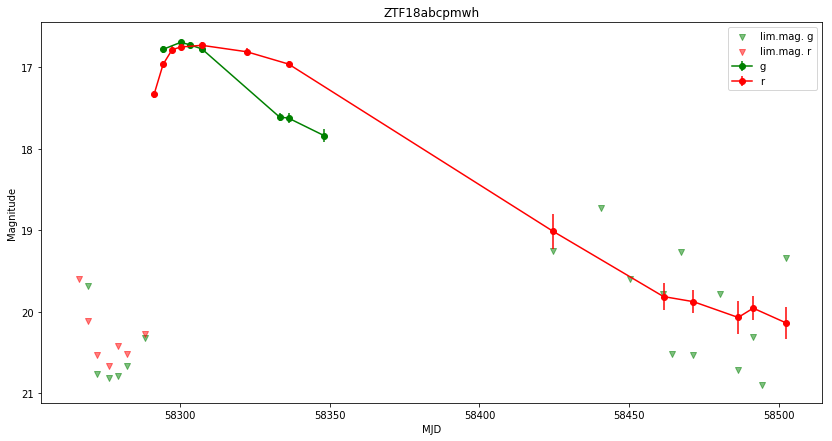

In [16]:
#seloid = np.random.choice(SNe.index)
print(seloid)
LCdet, LCnondet = getSNdata(seloid, doLC=True, dostamp=True, doNED=True);

In [17]:
LCdet.shape, LCnondet.shape

((20, 8), (25, 4))

In [18]:
aladin= ipyal.Aladin(target='%s %s' % (SNe.meanra[seloid], SNe.meandec[seloid]), fov=0.04, survey='P/PanSTARRS/DR1/color-z-zg-g', reticle_size= 64)
display(aladin)

Aladin(fov=0.04, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'o…

### Try more SNe

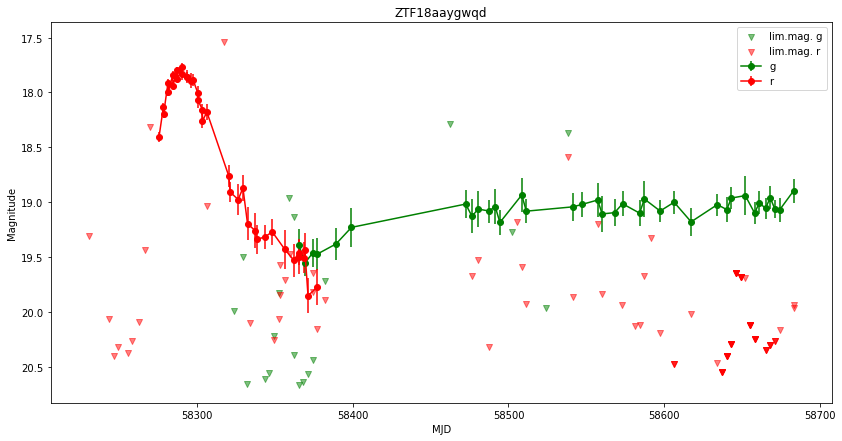

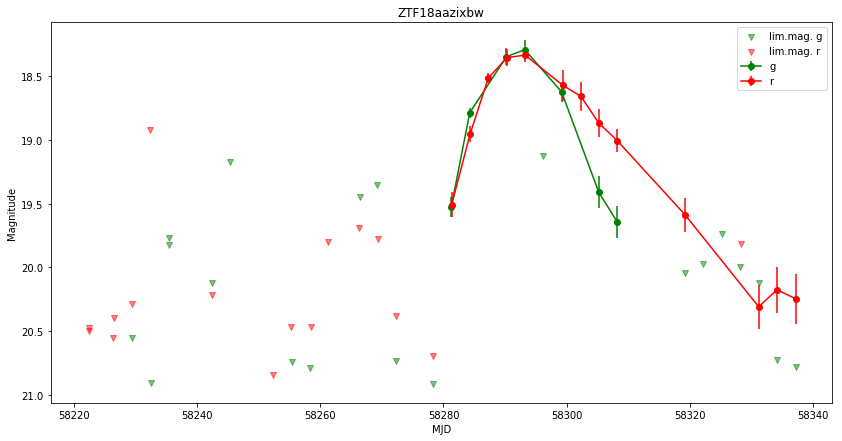

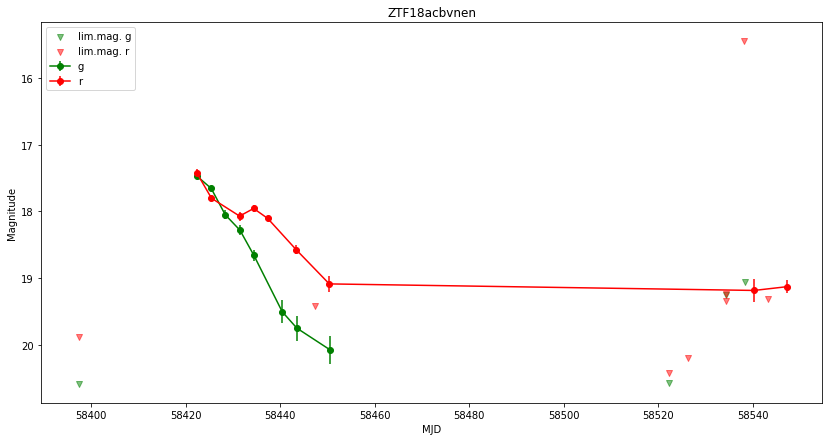

In [19]:
for idx, oid in enumerate(SNe.index):
    if np.mod(idx, 60) == 0:
        getSNdata(oid, doLC = True, dostamp=True, doNED = False);